<a href="https://www.kaggle.com/code/vadimdmls/iubip-face-recognition?scriptVersionId=168718320" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Face recognition 
using face embeddings, which provides higher performance compared to CNN

In [1]:
%%capture
!pip install mtcnn
!pip install facenet-pytorch

In [2]:
import numpy as np
import pandas as pd 
import os
import shutil
import random
from scipy.spatial.distance import cosine
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from facenet_pytorch import MTCNN, InceptionResnetV1 
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dir = '/kaggle/working/test-faces'
base_path = '/kaggle/input/face-recognition-dataset/Face Data/Face Dataset'
target_path = '/kaggle/working/need-faces'
root_path = '/kaggle/working/need-faces'
no_real = '/kaggle/working/no-real'

In [3]:
def create_root_dir(base_path, target_path):
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
            if num_images > 3:
                target_folder_path = os.path.join(target_path, folder_name)
                shutil.copytree(folder_path, target_folder_path)
    print(f"Подпапки с более чем 3 изображениями были скопированы в {target_path}")

    
def create_test_dir(base_path, target_path):
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
            if num_images == 3:
                target_folder_path = os.path.join(target_path, folder_name)
                shutil.copytree(folder_path, target_folder_path)
    print(f"Подпапки с 3 изображениями были скопированы в {target_path}")

In [4]:
create_root_dir(base_path, target_path)
create_test_dir(base_path, no_real)

Подпапки с более чем 3 изображениями были скопированы в /kaggle/working/need-faces
Подпапки с 3 изображениями были скопированы в /kaggle/working/no-real


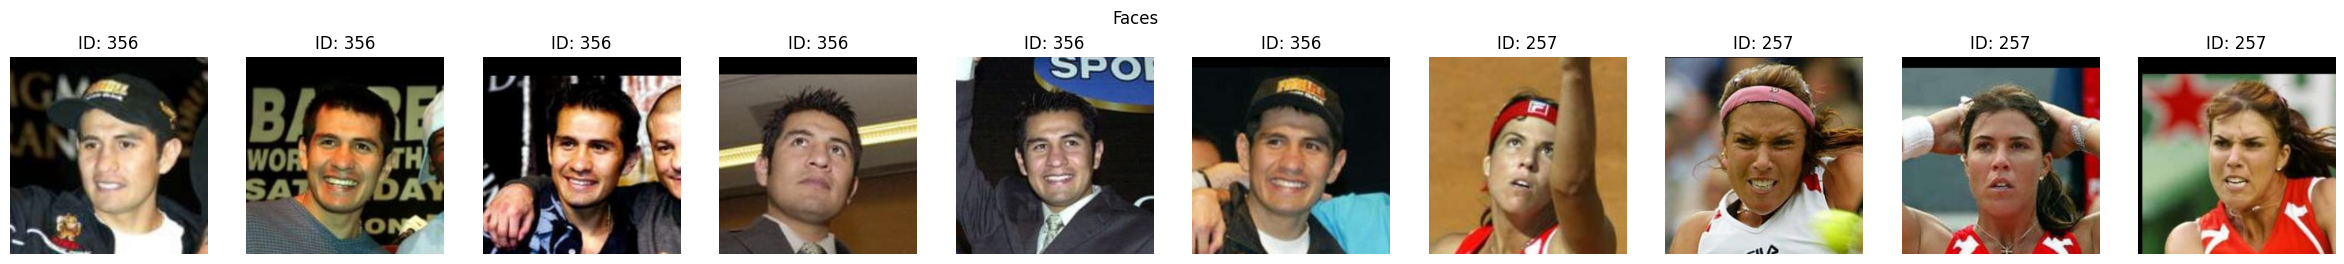

In [5]:
class FacesDataset(Dataset):
    def __init__(self, root_dir, transform=None, mtcnn=None):
        # Обход всех подпапок и сбор информации об изображениях
        self.transform = transform
        self.mtcnn = mtcnn
        self.file_list = []
        self.labels = []
        all_labels = []  # Список для хранения всех меток для LabelEncoder
        
        # Обход всех подпапок и сбор информации об изображениях
        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            label = int(folder_name)  # Преобразование названия папки в метку
            all_labels.append(label)  # Добавление метки в список всех меток
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.jpg')):
                    self.file_list.append(os.path.join(folder_path, filename))
                    self.labels.append(label)
        
        # Инициализация и обучение LabelEncoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(all_labels)
        # Преобразование всех меток в индексы
        self.encoded_labels = self.label_encoder.transform(self.labels)
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path).convert("RGB")
        if self.mtcnn:
            boxes, _ = self.mtcnn.detect(img)
            if boxes is not None:
                box = boxes[0]
                img = img.crop((box[0], box[1], box[2], box[3]))
            else:
                raise Exception(f"Face not detected by MTCNN in file: {img_path}")
                
        label = self.encoded_labels[index]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle(title)
    for i, index in enumerate(display_indices):
        x, y = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title(f"ID: {y}")
        plt.imshow(x)  
        plt.grid(False)
        plt.axis('off')
    plt.show()
# Use this elemets    
dataset = FacesDataset(root_path)
visualize_samples(dataset, range(len(dataset)), title="Faces")

In [6]:
mtcnn = MTCNN(device=device, image_size=160, keep_all=False)

batch_size = 64
train_dataset = FacesDataset(root_path,transform = transforms.Compose([
                                                    transforms.Resize((160, 160)), 
                                                    transforms.ToTensor(), 
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                ]), mtcnn=mtcnn)
control_dataset = FacesDataset(no_real,transform = transforms.Compose([
                                                    transforms.Resize((160, 160)), 
                                                    transforms.ToTensor(), 
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                ]), mtcnn=mtcnn)

indices_per_label = defaultdict(list)
for idx in range(len(dataset)):
    _, label = dataset[idx]
    indices_per_label[label].append(idx)

selected_indices = []
remaining_indices = []
for label, indices in indices_per_label.items():
    selected_index = random.choice(indices)
    selected_indices.append(selected_index)
    
    remaining_indices.extend([idx for idx in indices if idx != selected_index])

# Создаем Subset датасеты с выбранными индексами и оставшимися индексами
subset_dataset_selected = Subset(train_dataset, selected_indices)
subset_dataset_remaining = Subset(train_dataset, remaining_indices)

train_loader = torch.utils.data.DataLoader(subset_dataset_remaining, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(subset_dataset_selected, batch_size=batch_size)
control_loader = torch.utils.data.DataLoader(control_dataset, batch_size=batch_size)

In [7]:
def get_embeddings(model, data_loader):
    model.eval()  # Переключаем модель в режим оценки
    embeddings = []  # Список для хранения эмбеддингов
    labels = []  # Список для хранения меток
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, batch_labels in data_loader:
            images = images.to(device)  # Переносим изображения на устройство
            batch_embeddings = model(images)  # Получаем эмбеддинги для пакета изображений
            embeddings.append(batch_embeddings)
            labels.append(batch_labels)
    
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    print('Embedding are ready')
    return embeddings, labels


def average_embeddings_by_label(embeddings, labels):
    unique_labels = labels.unique()  # Получаем уникальные метки
    averaged_embeddings = torch.zeros((len(unique_labels), embeddings.size(1))).to(device)  # Тензор для хранения усредненных эмбеддингов
    
    for i, label in enumerate(unique_labels):
        # Индексы эмбеддингов, соответствующих текущей метке
        indices = (labels == label).nonzero(as_tuple=True)[0]
        # Усреднение эмбеддингов для текущей метки
        averaged_embeddings[i] = embeddings[indices].mean(dim=0)
    
    return averaged_embeddings, unique_labels

def get_random_embedding_per_label(model, data_loader):
    model.eval()  # Переключаем модель в режим оценки
    embeddings_dict = defaultdict(list)
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, labels in data_loader:
            images = images.to(device)  # Переносим изображения на устройство модели
            embeddings = model(images)  # Получаем эмбеддинги для пакета изображений
            for embedding, label in zip(embeddings, labels):
                embeddings_dict[label.item()].append(embedding)
    
    # Выбираем случайный эмбеддинг для каждой метки
    random_embeddings = {label: random.choice(embeddings) for label, embeddings in embeddings_dict.items()}
    
    # Преобразуем словарь в список эмбеддингов и соответствующих меток
    unique_labels = list(random_embeddings.keys())
    random_embedding_list = list(random_embeddings.values())
    
    # Стекаем список эмбеддингов в один тензор
    random_embeddings_tensor = torch.stack(random_embedding_list)
    
    return random_embeddings_tensor, unique_labels

In [8]:
model = InceptionResnetV1(pretrained='vggface2').eval()
model.to(device)
# random_embeddings, labels = get_random_embedding_per_label(model, train_loader)
embeddings, labels = get_embeddings(model, train_loader)
averaged_embeddings, unique_labels = average_embeddings_by_label(embeddings, labels)

  0%|          | 0.00/107M [00:00<?, ?B/s]

Embedding are ready


In [15]:
len(test_loader)
# len(control_loader)

10

In [16]:
def evaluate_accuracy(data_loader, model, reference_embeddings, reference_labels, threshold=0.38):
    model.eval()
    correct_matches = 0
    total_samples = 0
    all_labels = []
    distances = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            batch_embeddings = model(images)
            
            for i, input_embedding in enumerate(batch_embeddings):
                input_embedding = input_embedding.squeeze()
                min_distance = float('inf')
                min_index = None
                
                # Перебор всех эталонных эмбеддингов и поиск ближайшего
                for j, ref_embedding in enumerate(reference_embeddings):
                    distance = cosine(input_embedding.cpu().numpy(), ref_embedding.cpu().numpy())
                    if distance < min_distance:
                        min_distance = distance
                        min_index = j
                        
                distances.append(min_distance)
                
                if len(data_loader) == 10:
                # Проверка, не превышает ли найденное расстояние пороговое значение
                    if min_distance < threshold:
                        predicted_label = reference_labels[min_index]
                    else:
                        predicted_label = None

                    # Подсчет правильных совпадений
                    if predicted_label == labels[i]:
                        correct_matches += 1
                    total_samples += 1
#             all_labels.extend(labels.tolist())
#     # Вычисление точности
#     accuracy = correct_matches / total_samples
                else:
                    if min_distance < threshold:
                        correct_matches += 1
                        # Подсчет правильных совпадений

                    total_samples += 1
#             all_labels.extend(labels.tolist())
#         # Вычисление точности
#     accuracy = correct_matches / total_samples
            all_labels.extend(labels.tolist())
    # Вычисление точности
    accuracy = correct_matches / total_samples
    return accuracy, all_labels, distances

# People who are in the database(new photos)

In [19]:
accuracy, labels_faces, distances = evaluate_accuracy(test_loader, model, averaged_embeddings, unique_labels)
print(f'Точность распознавания: {accuracy}')

Точность распознавания: 0.898360655737705


# People who are not in the database

In [20]:
accuracy, labels_faces, distances = evaluate_accuracy(control_loader, model, averaged_embeddings, unique_labels)
print(f'Показатель ошибки предсказания: {accuracy}')

Показатель ошибки предсказания: 0.1718213058419244


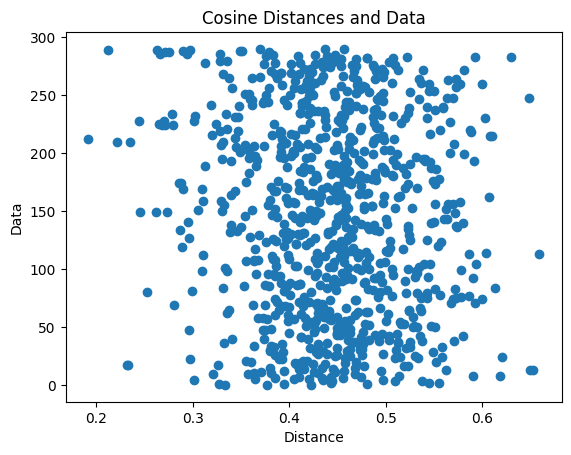

In [11]:
import matplotlib.pyplot as plt
# Построение график
plt.scatter(distances, labels_faces)
plt.xlabel('Distance')
plt.ylabel('Data')
plt.title('Cosine Distances and Data')
plt.show()